In [408]:
import pandas as pd
import numpy as np
import sys
import nltk
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.lancaster import LancasterStemmer
from collections import Counter
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from SALib.analyze import sobol as sobol_analyzer
from SALib.analyze import morris as morris_analyzer
from SALib.sample import saltelli as saltelli_sampler
from SALib.sample import morris as morris_sampler

import matplotlib.pyplot as plt

import re

%matplotlib inline


# Data preparation

In [231]:
data = pd.read_csv('train.csv')
count_vec = CountVectorizer(stop_words='english')
tokenizer_drop_stop_words = count_vec.build_analyzer()
stemmer = LancasterStemmer()

def spell_corr(x):
    spell_corr = TextBlob(x)
    return str(spell_corr.correct())

def preprocesser(x, tokenizer, drop_numbers=False, stemmer=stemmer, spell_check=False):
    if spell_check:
        x = spell_corr(x)
    tokens = [word for word in tokenizer(x)]
    if drop_numbers:
        tokens = [word for word in tokens if not word.isnumeric()]
    if stemmer:
        tokens = [stemmer.stem(token) for token in tokens]
    return tokens

count_vec = CountVectorizer(tokenizer=lambda x: preprocesser(x, tokenizer_drop_stop_words, drop_numbers=True))
count_feature = count_vec.fit_transform(data['comment_text'])

In [232]:
features = pd.read_csv('features.csv')
features.drop(['Unnamed: 0'],  axis=1, inplace=True)
features.fillna(0.5, inplace=True)
target = data[['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

full_features = sparse.hstack((features,count_feature))
X_train, X_test, y_train, y_test = train_test_split(full_features, target,test_size = 0.2, random_state = 42)

features_train,count_feature_train =  X_train[:,:16], X_train[:,16:]
features_test, count_feature_test  =  X_test[:,:16],  X_test[:,16:]

### Dimentionality reduction

In [235]:
n_components = [10,50,100,150,200,250,300]
variance_ratio = []
for n in tqdm(n_components):
    svd = TruncatedSVD(n_components=n, random_state=42)
    count_train_svd = svd.fit_transform(count_feature_train)  
    count_test_svd = svd.transform(count_feature_test) 
    variance_ratio.append(svd.explained_variance_ratio_.sum())

100%|██████████| 7/7 [05:54<00:00, 50.71s/it]


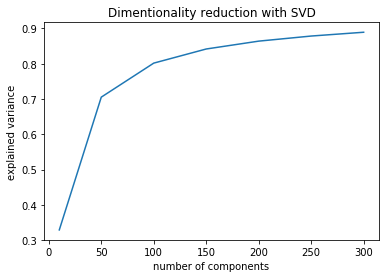

In [240]:
plt.plot(n_components, variance_ratio)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.title('Dimentionality reduction with SVD')
plt.show()

Let's consider 150 components

In [243]:
svd = TruncatedSVD(n_components=150, random_state=42)
count_train_svd = svd.fit_transform(count_feature_train)  
count_test_svd = svd.transform(count_feature_test) 
print('explained variance for 150 components: {}'.format(svd.explained_variance_ratio_.sum()))

explained variance for 150 ccomponents: 0.841632263407


In [244]:
features_train = sparse.csr_matrix.todense(features_train)
features_test = sparse.csr_matrix.todense(features_test)

X_train = np.hstack((count_train_svd, features_train))
X_test = np.hstack((count_test_svd, features_test))

### Data scaling

In [245]:
sc = StandardScaler()
X_train_tr = sc.fit_transform(X_train)
X_test_tr = sc.transform(X_test)

# Best models per targer selection

In [338]:
best_models = [DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), \
               DecisionTreeClassifier(), DecisionTreeClassifier()]

best_scores =  np.zeros(y_train.shape[1])
best_scores_test =  np.zeros(y_train.shape[1])

best_est = list(np.zeros(y_train.shape[1]))

In [344]:
columns = ['Target', 'Dataset', 'Dimensionreduction', 'FeatureSelection', 'Model', 'Parameters', 'ValidationScore', \
           'Std', 'TestScore']
results = pd.DataFrame(columns=columns)
index = 0

### Decision Tree Classifier

0it [00:00, ?it/s]

DT toxic best score: 0.845192435466
DT toxic best param: {'max_depth': 7}


1it [01:37, 97.91s/it]

DT severe_toxic best score: 0.930757731225
DT severe_toxic best param: {'max_depth': 4}


2it [02:57, 88.93s/it]

DT obscene best score: 0.920479626679
DT obscene best param: {'max_depth': 5}


3it [04:25, 88.50s/it]

DT threat best score: 0.801772534633
DT threat best param: {'max_depth': 3}


4it [05:40, 85.01s/it]

DT insult best score: 0.87785508145
DT insult best param: {'max_depth': 5}


5it [07:09, 85.98s/it]

DT identity_hate best score: 0.872815366205
DT identity_hate best param: {'max_depth': 4}


6it [08:31, 85.31s/it]


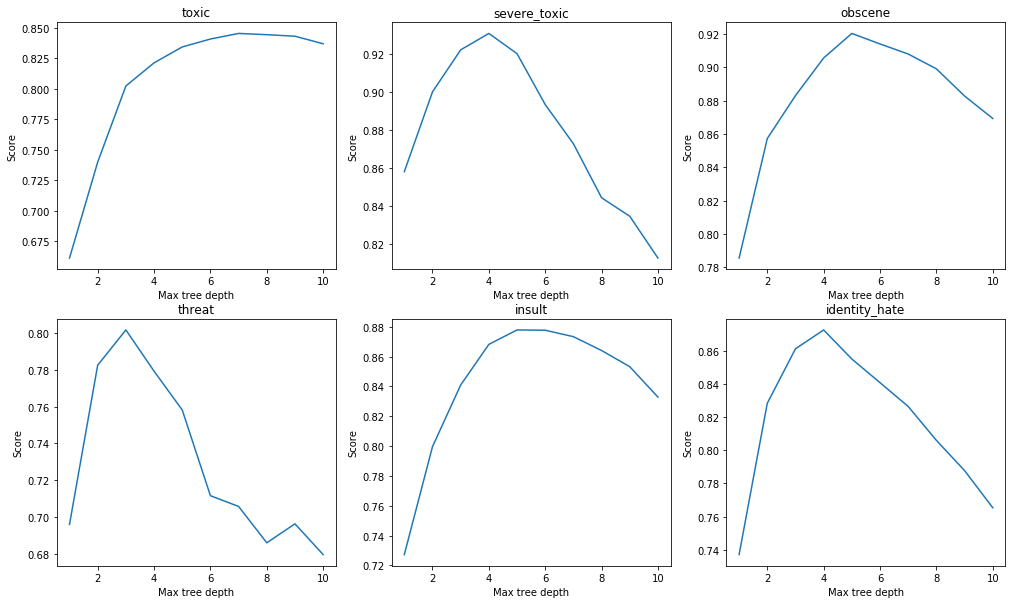

In [345]:
parameters_DT = {'max_depth': np.arange(1,11)}

plt.figure(figsize = (17,10))

for i, column in tqdm(enumerate(y_train.columns)): 
    model = DecisionTreeClassifier(class_weight='balanced')
    grid_search = GridSearchCV(model, parameters_DT, cv = 3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_tr, y_train[column])
    print('DT {} best score: {}'.format(column, grid_search.best_score_))
    print('DT {} best param: {}'.format(column, grid_search.best_params_))
    
    best_estimator = grid_search.best_estimator_
    best_estimator.fit(X_train_tr, y_train[column])
    y_pred = best_estimator.predict(X_test_tr)
    roc_auc = roc_auc_score(y_test[column], y_pred)
    
    if grid_search.best_score_ > best_scores[i]:
        best_models[i] = grid_search.best_estimator_
        best_scores[i] = grid_search.best_score_
        best_est[i] = 'DT'
        best_scores_test[i] = roc_auc

    results.loc[index] = [column, 'CountVectorizer', 'SVD', '-', 'Decision Tree',  grid_search.best_params_, \
                          grid_search.best_score_,grid_search.cv_results_['std_test_score'][grid_search.best_index_], roc_auc]

    index += 1
    
    plt.subplot(2,3,i+1)
    plt.plot(grid_search.cv_results_['param_max_depth'], grid_search.cv_results_['mean_test_score'])
    plt.xlabel('Max tree depth')
    plt.ylabel('Score')
    plt.title(column)
    
plt.show()

### Naive Bayes Classifier 

NB toxic best score: 0.838970903061
NB toxic best param: {'alpha': 1000}
NB severe_toxic best score: 0.951689019439
NB severe_toxic best param: {'alpha': 100.0}
NB obscene best score: 0.897097756796
NB obscene best param: {'alpha': 500}
NB threat best score: 0.895063972064
NB threat best param: {'alpha': 30.0}
NB insult best score: 0.875320471496
NB insult best param: {'alpha': 500}
NB identity_hate best score: 0.904395126073
NB identity_hate best param: {'alpha': 100.0}


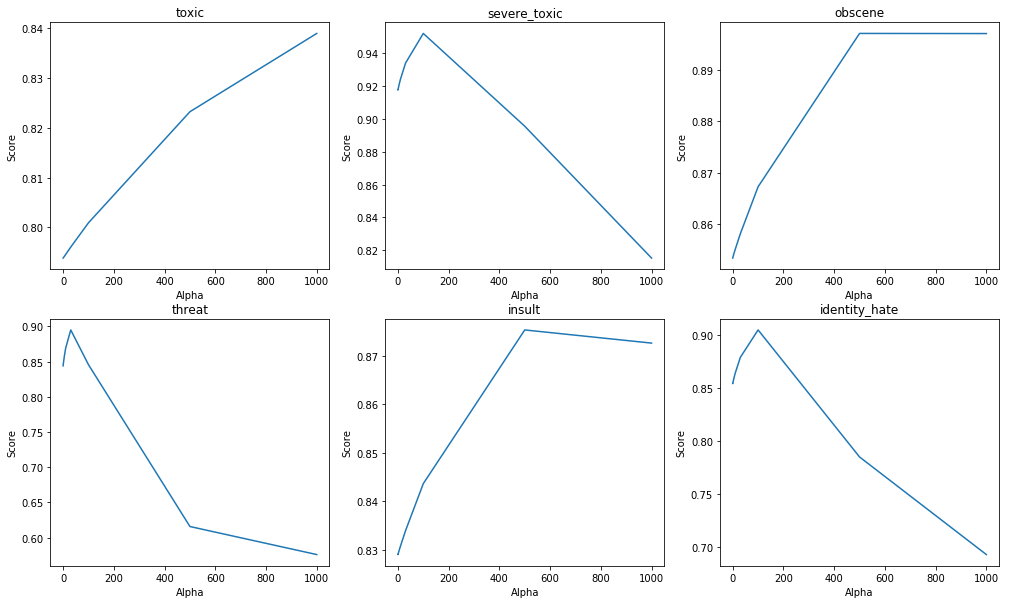

In [348]:
parameters_NB = {'alpha': [1e-5, 1e-3, 0.1, 1.0, 5.0, 10., 30., 100., 500, 1000]}

plt.figure(figsize = (17,10))

for i, column in enumerate(y_train.columns): 
    model = BernoulliNB()
    grid_search = GridSearchCV(model, parameters_NB, cv = 3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_tr, y_train[column])
    print('NB {} best score: {}'.format(column, grid_search.best_score_))
    print('NB {} best param: {}'.format(column, grid_search.best_params_))
    
    best_estimator = grid_search.best_estimator_
    best_estimator.fit(X_train_tr, y_train[column])
    y_pred = best_estimator.predict(X_test_tr)
    roc_auc = roc_auc_score(y_test[column], y_pred)
    
    if grid_search.best_score_ > best_scores[i]:
        best_models[i] = grid_search.best_estimator_
        best_scores[i] = grid_search.best_score_
        best_est[i] = 'NB'
        best_scores_test[i] = roc_auc
    
    results.loc[index] = [column, 'CountVectorizer', 'SVD', '-', 'Naive Bayes',  grid_search.best_params_, \
                          grid_search.best_score_,grid_search.cv_results_['std_test_score'][grid_search.best_index_], roc_auc]

    index += 1
    
    plt.subplot(2,3,i+1)
    plt.plot(grid_search.cv_results_['param_alpha'], grid_search.cv_results_['mean_test_score'])
    plt.xlabel('Alpha')
    plt.ylabel('Score')
    plt.title(column)
plt.show()

## Logistic Regression

0it [00:00, ?it/s]

LR toxic best score: 0.921834688033
LR toxic best param: {'C': 1.0}


1it [02:39, 159.54s/it]

LR severe_toxic best score: 0.963322006233
LR severe_toxic best param: {'C': 0.1}


2it [05:51, 175.72s/it]

LR obscene best score: 0.956656721501
LR obscene best param: {'C': 5.0}


3it [08:10, 163.43s/it]

LR threat best score: 0.927756738021
LR threat best param: {'C': 0.01}


4it [10:25, 156.39s/it]

LR insult best score: 0.936958507754
LR insult best param: {'C': 5.0}


5it [12:53, 154.69s/it]

LR identity_hate best score: 0.926060095896
LR identity_hate best param: {'C': 1.0}


6it [15:31, 155.26s/it]


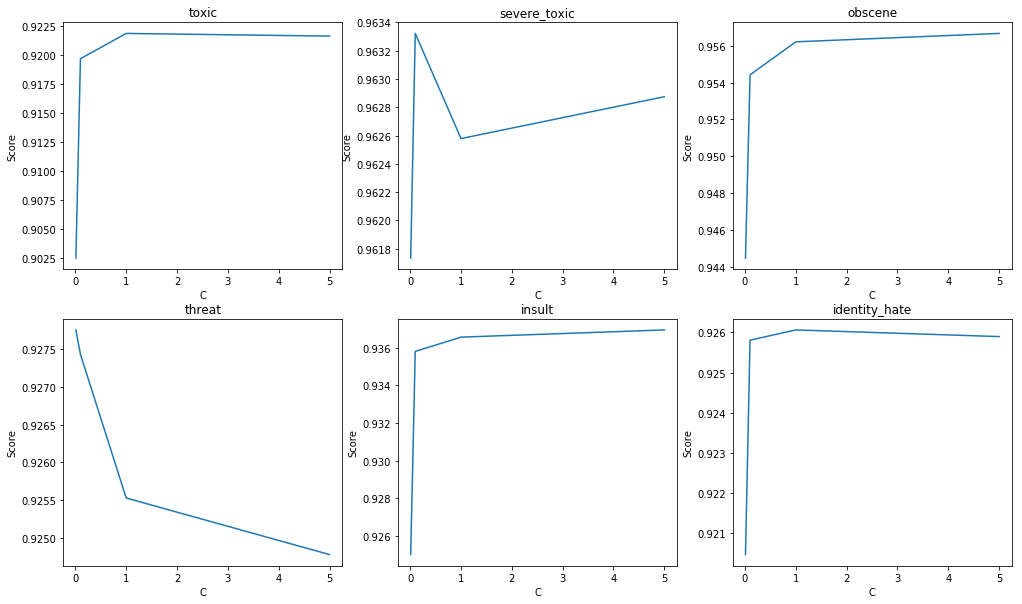

In [349]:
parameters_LR = {'C': [1e-2, 0.1, 1.0, 5.0]}

plt.figure(figsize = (17,10))

for i, column in tqdm(enumerate(y_train.columns)): 
    model = LogisticRegression(class_weight='balanced')
    grid_search = GridSearchCV(model, parameters_LR, cv = 3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_tr, y_train[column])
    print('LR {} best score: {}'.format(column, grid_search.best_score_))
    print('LR {} best param: {}'.format(column, grid_search.best_params_))
    
    best_estimator = grid_search.best_estimator_
    best_estimator.fit(X_train_tr, y_train[column])
    y_pred = best_estimator.predict(X_test_tr)
    roc_auc = roc_auc_score(y_test[column], y_pred)

    
    if grid_search.best_score_ > best_scores[i]:
        best_models[i] = grid_search.best_estimator_
        best_scores[i] = grid_search.best_score_
        best_est[i] = 'LR'
        best_scores_test[i] = roc_auc

        
    results.loc[index] = [column, 'CountVectorizer', 'SVD', '-', 'Logistic Regression',  grid_search.best_params_, \
                         grid_search.best_score_,grid_search.cv_results_['std_test_score'][grid_search.best_index_], roc_auc]

    index += 1
    
    plt.subplot(2,3,i+1)
    plt.plot(grid_search.cv_results_['param_C'], grid_search.cv_results_['mean_test_score'])
    plt.xlabel('C')
    plt.ylabel('Score')
    plt.title(column)
    
plt.show()

# Results for test for best models per target

In [350]:
for i, column in enumerate(y_train.columns): 
    print('Best model for {} : {}, test score: {}'.format(column, best_est[i], best_scores_test[i]))

Best model for toxic : LR, test score: 0.845978592612
Best model for severe_toxic : LR, test score: 0.918676394055
Best model for obscene : LR, test score: 0.900195248393
Best model for threat : LR, test score: 0.897439303567
Best model for insult : LR, test score: 0.856523050613
Best model for identity_hate : LR, test score: 0.861929889441


# Feature Selection using Morris analyzer

In [351]:
problem = {
    'num_vars': 166,
    'names': np.hstack((np.arange(150),features.columns.values)),
    'bounds': np.vstack((np.array(X_train.min(axis = 0)), np.array(X_train.max(axis = 0)))).T,
    'groups': None
    }

X_mor = morris_sampler.sample(problem, 1000, grid_jump = 2,num_levels = 4)

In [352]:
important_features_index = {}
def morris_analys(i, threshold, print_to_console=False):
    y_mor = best_models[i].predict(X_mor)
    MO = morris_analyzer.analyze(problem,X_mor, np.array(y_mor, dtype=float ), print_to_console = print_to_console)
    column = y_train.columns[i]
    print('important features for {} :'.format(column))
    print(np.hstack((np.arange(150),features.columns.values))[np.where(MO['mu_star'] > threshold)[0]])
    print(' \n')
    important_features_index[column] = np.where(MO['mu_star'] > threshold)[0]
    
for i in range(len(y_train.columns)):
    morris_analys(i, 0.00)

important features for toxic :
[0 1 3 6 7 8 12 15 16 23 24 30 33 55 'number_exclamation_marks' 'pronouns']
 

important features for severe_toxic :
[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26 27 28 29
 30 31 33 35 36 38 40 41 42 43 44 45 46 47 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 64 65 66 68 69 71 72 74 77 79 80 81 82 83 86 87 88 89 90 91 92 93
 95 97 99 101 105 106 108 109 112 116 117 119 120 121 123 124 126 127 129
 132 133 135 138 139 141 142 143 145 147 148 'length'
 'number_exclamation_marks' 'subjectivity' 'polarity' 'adjectives'
 'adverbs' 'verbs' 'nouns' 'question' 'pronouns']
 

important features for obscene :
[0 1 2 3 4 6 7 8 9 10 11 12 13 15 16 17 22 23 24 26 27 28 29 30 33 34 35 36
 37 40 42 43 44 45 46 47 51 52 53 54 55 58 61 62 65 66 67 69 70 71 73 74 75
 76 78 82 83 86 88 91 97 110 123 127 129 131 132 133 137 141 143 'length'
 'number_exclamation_marks' 'adjectives' 'nouns' 'pronouns'
 'num_superlative']
 

important features for threat :
[0 

# Model Selection after Feature selection

In [353]:
best_models_reduced = [DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), \
                       DecisionTreeClassifier(), DecisionTreeClassifier()]

best_scores_reduced =  np.zeros(y_train.shape[1])
best_scores_test_reduced = np.zeros(y_train.shape[1])

best_est_reduced = list(np.zeros(y_train.shape[1]))

## Decision Tree 

0it [00:00, ?it/s]

DT toxic best score: 0.836038449516
DT toxic best param: {'max_depth': 8}


1it [00:10, 10.68s/it]

DT severe_toxic best score: 0.932301983974
DT severe_toxic best param: {'max_depth': 4}


2it [01:09, 34.65s/it]

DT obscene best score: 0.915462594791
DT obscene best param: {'max_depth': 5}


3it [01:51, 37.20s/it]

DT threat best score: 0.80182594254
DT threat best param: {'max_depth': 3}


4it [02:45, 41.46s/it]

DT insult best score: 0.864171217809
DT insult best param: {'max_depth': 7}


5it [03:40, 44.01s/it]

DT identity_hate best score: 0.859325688966
DT identity_hate best param: {'max_depth': 3}


6it [04:36, 46.14s/it]


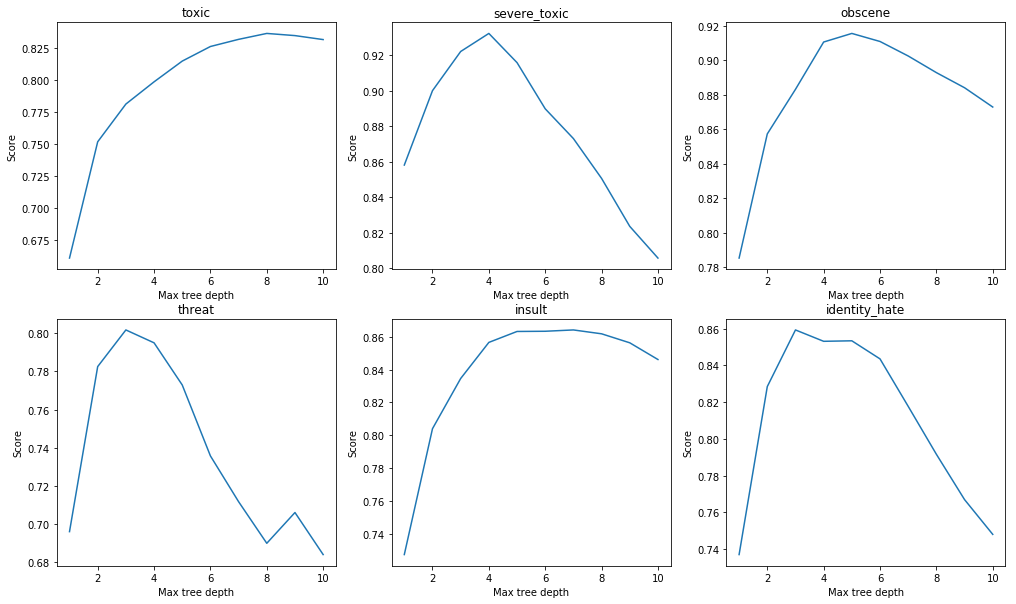

In [354]:
plt.figure(figsize = (17,10))

for i, column in tqdm(enumerate(y_train.columns)): 
    model = DecisionTreeClassifier(class_weight='balanced')
    grid_search = GridSearchCV(model, parameters_DT, cv = 3, scoring='roc_auc', n_jobs=-1)
    
    train_reduced = X_train_tr[:, important_features_index[column]]
    grid_search.fit(train_reduced, y_train[column])
    print('DT {} best score: {}'.format(column, grid_search.best_score_))
    print('DT {} best param: {}'.format(column, grid_search.best_params_))
    
    best_estimator = grid_search.best_estimator_
    best_estimator.fit(train_reduced, y_train[column])
    test_reduced = X_test_tr[:, important_features_index[column]]
    y_pred = best_estimator.predict(test_reduced)
    roc_auc = roc_auc_score(y_test[column], y_pred)
    
    if grid_search.best_score_ > best_scores_reduced[i]:
        best_models_reduced[i] = grid_search.best_estimator_
        best_scores_reduced[i] = grid_search.best_score_
        best_est_reduced[i] = 'DT'
        best_scores_test_reduced[i] = roc_auc

    results.loc[index] = [column, 'CountVectorizer', 'SVD', 'morris', 'Decision Tree',  grid_search.best_params_, \
                          grid_search.best_score_,grid_search.cv_results_['std_test_score'][grid_search.best_index_], roc_auc]

    index += 1
    
    plt.subplot(2,3,i+1)
    plt.plot(grid_search.cv_results_['param_max_depth'], grid_search.cv_results_['mean_test_score'])
    plt.xlabel('Max tree depth')
    plt.ylabel('Score')
    plt.title(column)
    
plt.show()

## Naive Bayes

NB reduced toxic best score: 0.798152010461
NB reduced toxic best param: {'alpha': 500}
NB reduced severe_toxic best score: 0.952974352466
NB reduced severe_toxic best param: {'alpha': 100.0}
NB reduced obscene best score: 0.894913942641
NB reduced obscene best param: {'alpha': 500}
NB reduced threat best score: 0.892808962041
NB reduced threat best param: {'alpha': 30.0}
NB reduced insult best score: 0.861544762232
NB reduced insult best param: {'alpha': 500}
NB reduced identity_hate best score: 0.896820416363
NB reduced identity_hate best param: {'alpha': 100.0}


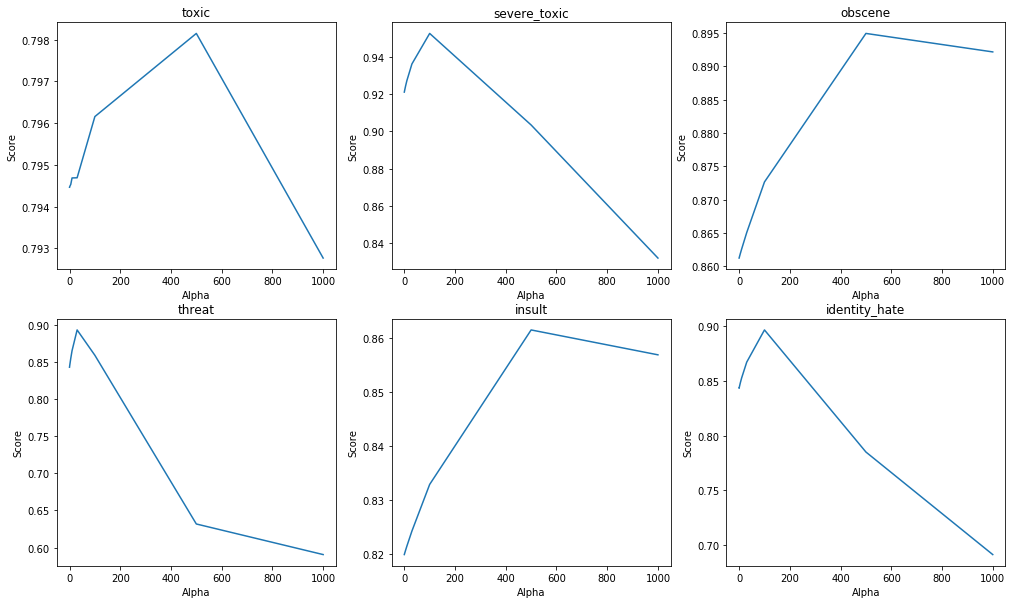

In [355]:
plt.figure(figsize = (17,10))

for i, column in enumerate(y_train.columns): 
    model = BernoulliNB()
    grid_search = GridSearchCV(model, parameters_NB, cv = 3, scoring='roc_auc', n_jobs=-1)
    train_reduced = X_train_tr[:, important_features_index[column]]
    grid_search.fit(train_reduced, y_train[column])
    print('NB reduced {} best score: {}'.format(column, grid_search.best_score_))
    print('NB reduced {} best param: {}'.format(column, grid_search.best_params_))
    
    best_estimator = grid_search.best_estimator_
    best_estimator.fit(train_reduced, y_train[column])
    test_reduced = X_test_tr[:, important_features_index[column]]
    y_pred = best_estimator.predict(test_reduced)
    roc_auc = roc_auc_score(y_test[column], y_pred)
    
    if grid_search.best_score_ > best_scores_reduced[i]:
        best_models_reduced[i] = grid_search.best_estimator_
        best_scores_reduced[i] = grid_search.best_score_
        best_est_reduced[i] = 'NB'
        best_scores_test_reduced[i] = roc_auc
    
    results.loc[index] = [column, 'CountVectorizer', 'SVD', 'morris', 'Naive Bayes',  grid_search.best_params_, \
                          grid_search.best_score_,grid_search.cv_results_['std_test_score'][grid_search.best_index_], roc_auc]

    index += 1
    
    plt.subplot(2,3,i+1)
    plt.plot(grid_search.cv_results_['param_alpha'], grid_search.cv_results_['mean_test_score'])
    plt.xlabel('Alpha')
    plt.ylabel('Score')
    plt.title(column)
plt.show()

## LogisticRegression

0it [00:00, ?it/s]

LR reduced toxic best score: 0.854692876467
LR reduced toxic best param: {'C': 5.0}


1it [00:18, 18.39s/it]

LR reduced severe_toxic best score: 0.968213893194
LR reduced severe_toxic best param: {'C': 0.1}


2it [02:32, 76.15s/it]

LR reduced obscene best score: 0.951133279358
LR reduced obscene best param: {'C': 1.0}


3it [03:49, 76.57s/it]

LR reduced threat best score: 0.936100391542
LR reduced threat best param: {'C': 0.01}


4it [05:26, 81.54s/it]

LR reduced insult best score: 0.922639549236
LR reduced insult best param: {'C': 1.0}


5it [06:47, 81.44s/it]

LR reduced identity_hate best score: 0.931022377665
LR reduced identity_hate best param: {'C': 1.0}


6it [08:30, 85.11s/it]


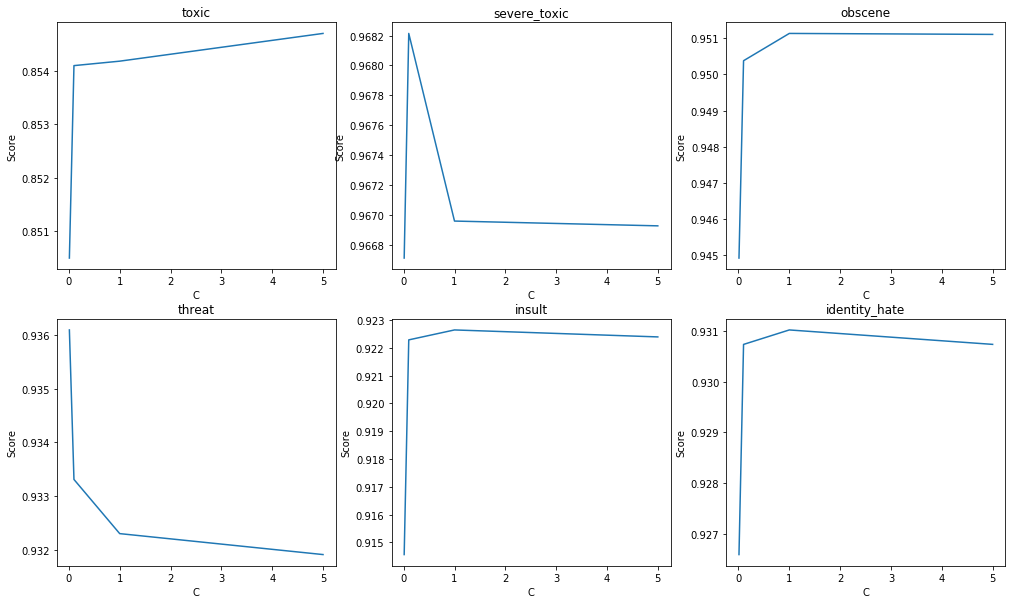

In [356]:
plt.figure(figsize = (17,10))

for i, column in tqdm(enumerate(y_train.columns)): 
    model = LogisticRegression(class_weight='balanced')
    grid_search = GridSearchCV(model, parameters_LR, cv = 3, scoring='roc_auc', n_jobs=-1)
    train_reduced = X_train_tr[:, important_features_index[column]]
    grid_search.fit(train_reduced, y_train[column])    
    print('LR reduced {} best score: {}'.format(column, grid_search.best_score_))
    print('LR reduced {} best param: {}'.format(column, grid_search.best_params_))
    
    best_estimator = grid_search.best_estimator_
    best_estimator.fit(train_reduced, y_train[column])
    test_reduced = X_test_tr[:, important_features_index[column]]
    y_pred = best_estimator.predict(test_reduced)
    roc_auc = roc_auc_score(y_test[column], y_pred)

    if grid_search.best_score_ > best_scores_reduced[i]:
        best_models_reduced[i] = grid_search.best_estimator_
        best_scores_reduced[i] = grid_search.best_score_
        best_est_reduced[i] = 'LR'
        best_scores_test_reduced[i] = roc_auc

        
    results.loc[index] = [column, 'CountVectorizer', 'SVD', 'morris', 'Logistic Regression',  grid_search.best_params_, \
                         grid_search.best_score_,grid_search.cv_results_['std_test_score'][grid_search.best_index_], roc_auc]

    index += 1
    
    plt.subplot(2,3,i+1)
    plt.plot(grid_search.cv_results_['param_C'], grid_search.cv_results_['mean_test_score'])
    plt.xlabel('C')
    plt.ylabel('Score')
    plt.title(column)
    
plt.show()

## Results for test for reduced best models per target

In [357]:
for i, column in enumerate(y_train.columns): 
    print('Best model for {} : {}, test score: {}'.format(column, best_est_reduced[i], best_scores_test_reduced[i]))

Best model for toxic : LR, test score: 0.758101013204
Best model for severe_toxic : LR, test score: 0.917365269284
Best model for obscene : LR, test score: 0.884362075956
Best model for threat : LR, test score: 0.903296531669
Best model for insult : LR, test score: 0.830201159723
Best model for identity_hate : LR, test score: 0.86689494431


### Comparison

In [362]:
np.array(best_scores_test_reduced) > np.array(best_scores_test)

array([False, False, False,  True, False,  True], dtype=bool)

# Model Selection with Random Forest 

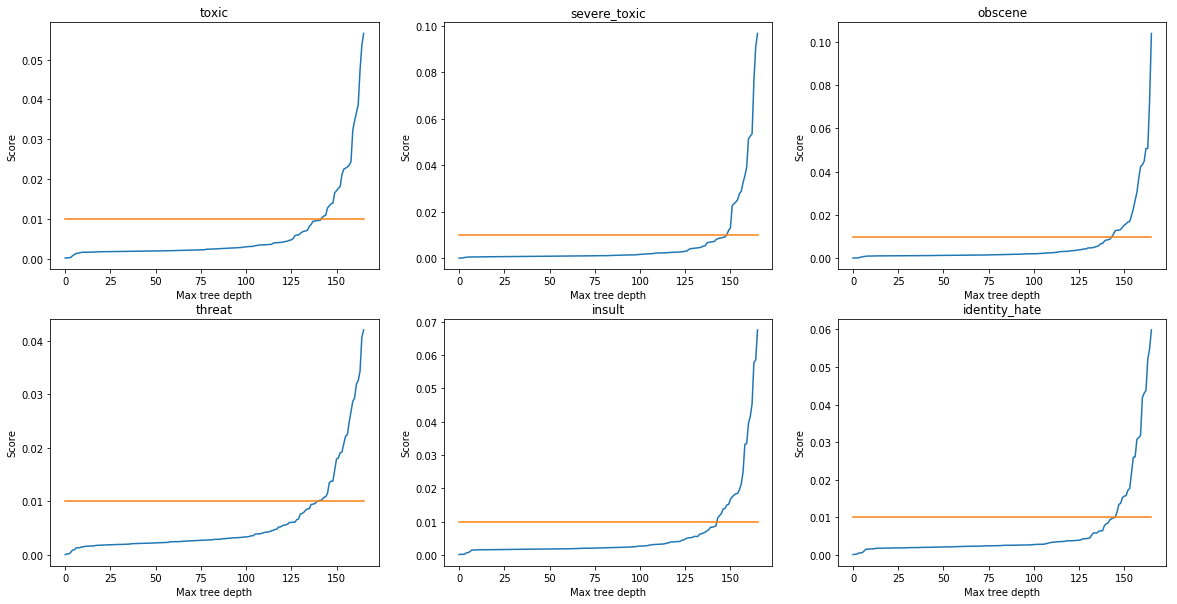

In [421]:
depth = [14, 10, 14, 10, 14, 14]
feature_importance_RF = {}
threshold = 0.01
plt.figure(figsize = (20,10))

for i, column in enumerate(y_train.columns): 
    model = RandomForestClassifier(class_weight='balanced', max_depth=depth[i], n_estimators = 200, n_jobs=-1)
    model.fit(X_train_tr, y_train[column])    
    plt.subplot(2,3,i+1)
    plt.plot(np.sort(model.feature_importances_))
    feature_importance[column] = np.where(model.feature_importances_ > threshold)
    plt.plot(np.arange(166), [threshold]*166, label='threshold')  
    plt.xlabel('Max tree depth')
    plt.ylabel('Score')
    plt.title(column)
    
plt.show()

In [435]:
columns = ['Target', 'Dataset', 'Dimensionreduction', 'FeatureSelection', 'Model', 'Parameters', 'ValidationScore', \
           'Std', 'TestScore']
results_RF = pd.DataFrame(columns=columns)
index = 0

In [440]:
best_models_RF = [DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), \
                       DecisionTreeClassifier(), DecisionTreeClassifier()]

best_scores_RF =  np.zeros(y_train.shape[1])
best_scores_test_RF = np.zeros(y_train.shape[1])

best_est_RF = list(np.zeros(y_train.shape[1]))

## Decision Trees

0it [00:00, ?it/s]

DT toxic best score: 0.852436916081
DT toxic best param: {'max_depth': 8}


1it [00:14, 14.34s/it]

DT severe_toxic best score: 0.940971489801
DT severe_toxic best param: {'max_depth': 4}


2it [00:23, 11.69s/it]

DT obscene best score: 0.923179013881
DT obscene best param: {'max_depth': 5}


3it [00:34, 11.52s/it]

DT threat best score: 0.803455645159
DT threat best param: {'max_depth': 3}


4it [00:46, 11.62s/it]

DT insult best score: 0.886977391997
DT insult best param: {'max_depth': 6}


5it [00:59, 11.89s/it]

DT identity_hate best score: 0.88924839278
DT identity_hate best param: {'max_depth': 4}


6it [01:09, 11.62s/it]


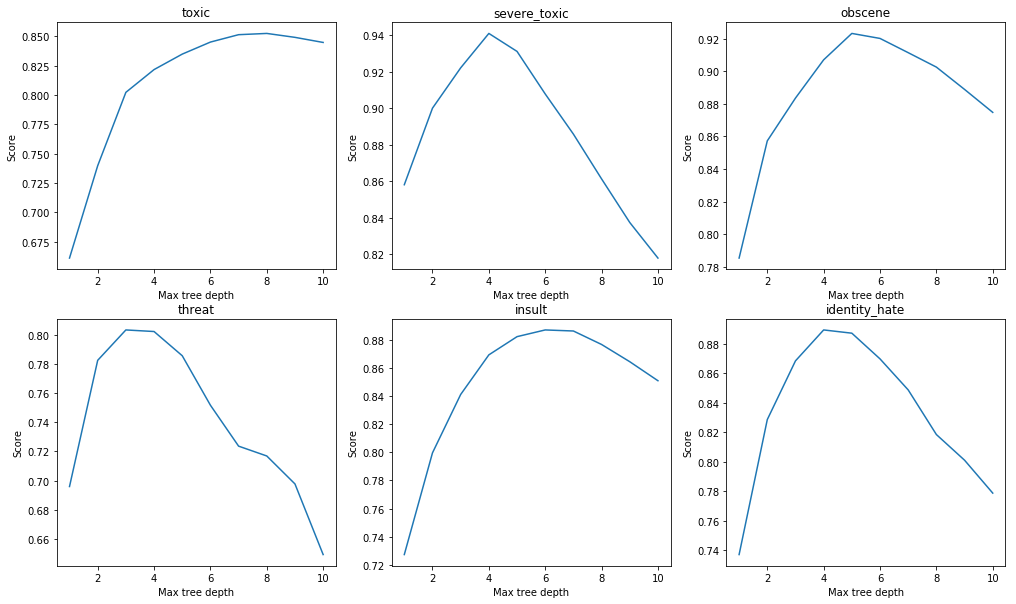

In [441]:
plt.figure(figsize = (17,10))

for i, column in tqdm(enumerate(y_train.columns)): 
    model = DecisionTreeClassifier(class_weight='balanced')
    grid_search = GridSearchCV(model, parameters_DT, cv = 3, scoring='roc_auc', n_jobs=-1)
    
    train_RF = X_train_tr[:, feature_importance[column][0]]
    grid_search.fit(train_RF, y_train[column])
    print('DT {} best score: {}'.format(column, grid_search.best_score_))
    print('DT {} best param: {}'.format(column, grid_search.best_params_))
    
    best_estimator = grid_search.best_estimator_
    best_estimator.fit(train_RF, y_train[column])
    test_RF = X_test_tr[:, feature_importance[column][0]]
    y_pred = best_estimator.predict(test_RF)
    roc_auc = roc_auc_score(y_test[column], y_pred)
    
    if grid_search.best_score_ > best_scores_RF[i]:
        best_models_RF[i] = grid_search.best_estimator_
        best_scores_RF[i] = grid_search.best_score_
        best_est_RF[i] = 'DT'
        best_scores_test_RF[i] = roc_auc

    results_RF.loc[index] = [column, 'CountVectorizer', 'SVD', 'Random Forest', 'Decision Tree',  grid_search.best_params_, \
                          grid_search.best_score_,grid_search.cv_results_['std_test_score'][grid_search.best_index_], roc_auc]

    index += 1
    
    plt.subplot(2,3,i+1)
    plt.plot(grid_search.cv_results_['param_max_depth'], grid_search.cv_results_['mean_test_score'])
    plt.xlabel('Max tree depth')
    plt.ylabel('Score')
    plt.title(column)
    
plt.show()

## Naive Bayes

NB reduced toxic best score: 0.820706338459
NB reduced toxic best param: {'alpha': 500}
NB reduced severe_toxic best score: 0.938216516068
NB reduced severe_toxic best param: {'alpha': 1e-05}
NB reduced obscene best score: 0.898282972484
NB reduced obscene best param: {'alpha': 5.0}
NB reduced threat best score: 0.876360575049
NB reduced threat best param: {'alpha': 10.0}
NB reduced insult best score: 0.865805057036
NB reduced insult best param: {'alpha': 1e-05}
NB reduced identity_hate best score: 0.8850080273
NB reduced identity_hate best param: {'alpha': 1e-05}


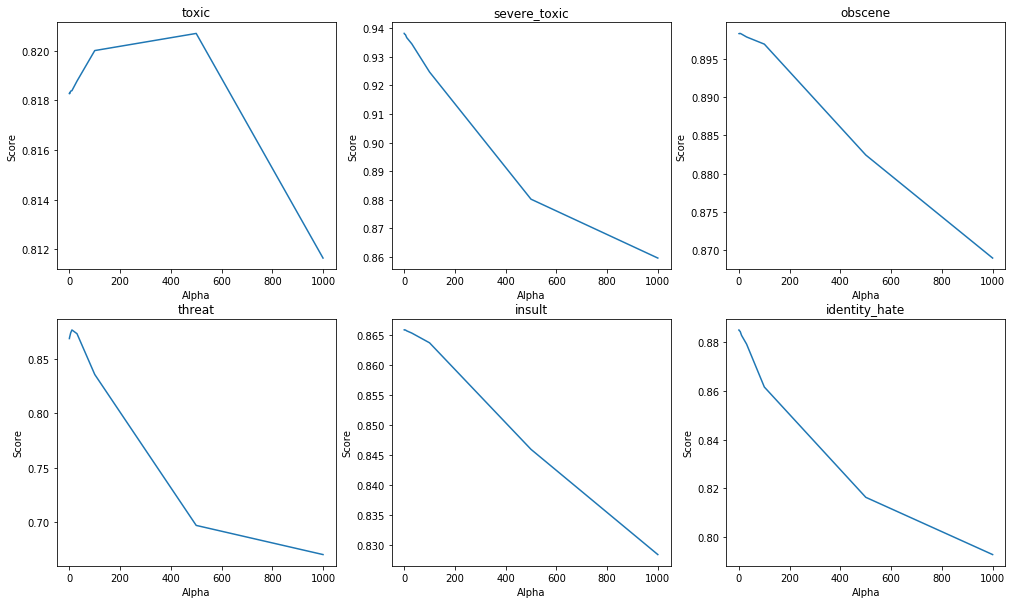

In [443]:
plt.figure(figsize = (17,10))

for i, column in enumerate(y_train.columns): 
    model = BernoulliNB()
    grid_search = GridSearchCV(model, parameters_NB, cv = 3, scoring='roc_auc', n_jobs=-1)
    train_reduced = X_train_tr[:, feature_importance[column][0]]
    grid_search.fit(train_reduced, y_train[column])
    print('NB reduced {} best score: {}'.format(column, grid_search.best_score_))
    print('NB reduced {} best param: {}'.format(column, grid_search.best_params_))
    
    best_estimator = grid_search.best_estimator_
    best_estimator.fit(train_reduced, y_train[column])
    test_reduced = X_test_tr[:, feature_importance[column][0]]
    y_pred = best_estimator.predict(test_reduced)
    roc_auc = roc_auc_score(y_test[column], y_pred)
    
    if grid_search.best_score_ > best_scores_RF[i]:
        best_models_RF[i] = grid_search.best_estimator_
        best_scores_RF[i] = grid_search.best_score_
        best_est_RF[i] = 'NB'
        best_scores_test_RF[i] = roc_auc
    
    results_RF.loc[index] = [column, 'CountVectorizer', 'SVD', 'Random Forest', 'Naive Bayes',  grid_search.best_params_, \
                          grid_search.best_score_,grid_search.cv_results_['std_test_score'][grid_search.best_index_], roc_auc]

    index += 1
    
    plt.subplot(2,3,i+1)
    plt.plot(grid_search.cv_results_['param_alpha'], grid_search.cv_results_['mean_test_score'])
    plt.xlabel('Alpha')
    plt.ylabel('Score')
    plt.title(column)
plt.show()

## LogisticRegression

0it [00:00, ?it/s]

LR reduced toxic best score: 0.870371926144
LR reduced toxic best param: {'C': 5.0}


1it [00:24, 24.47s/it]

LR reduced severe_toxic best score: 0.948350624598
LR reduced severe_toxic best param: {'C': 1.0}


2it [00:44, 22.09s/it]

LR reduced obscene best score: 0.923454274599
LR reduced obscene best param: {'C': 1.0}


3it [01:09, 23.23s/it]

LR reduced threat best score: 0.915655307308
LR reduced threat best param: {'C': 1.0}


4it [01:48, 27.02s/it]

LR reduced insult best score: 0.892613511056
LR reduced insult best param: {'C': 5.0}


5it [02:13, 26.69s/it]

LR reduced identity_hate best score: 0.913663277173
LR reduced identity_hate best param: {'C': 5.0}


6it [02:33, 25.64s/it]


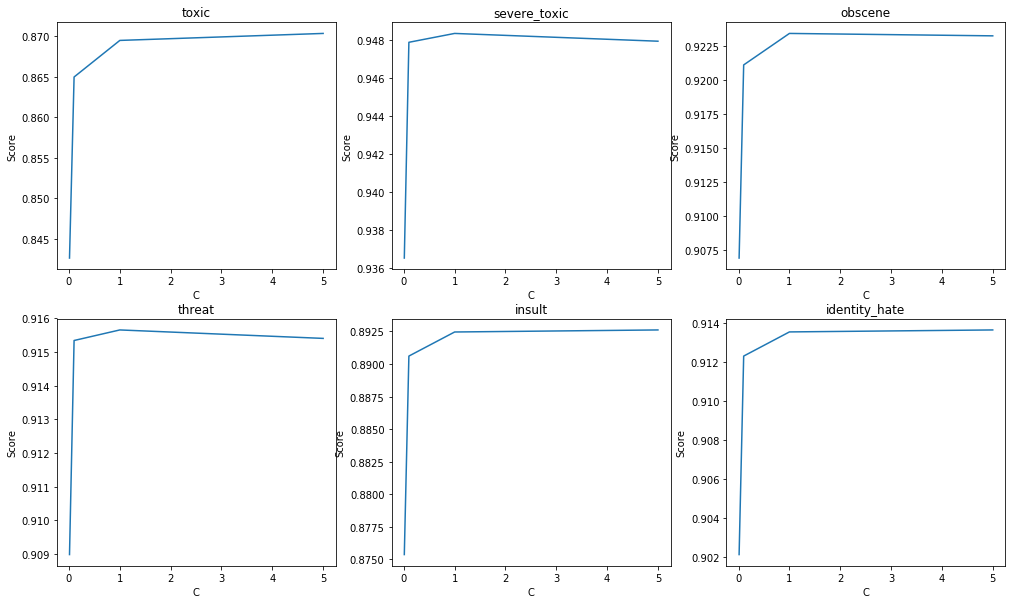

In [445]:
plt.figure(figsize = (17,10))

for i, column in tqdm(enumerate(y_train.columns)): 
    model = LogisticRegression(class_weight='balanced')
    grid_search = GridSearchCV(model, parameters_LR, cv = 3, scoring='roc_auc', n_jobs=-1)
    train_reduced = X_train_tr[:, feature_importance[column][0]]
    grid_search.fit(train_reduced, y_train[column])    
    print('LR reduced {} best score: {}'.format(column, grid_search.best_score_))
    print('LR reduced {} best param: {}'.format(column, grid_search.best_params_))
    
    best_estimator = grid_search.best_estimator_
    best_estimator.fit(train_reduced, y_train[column])
    test_reduced = X_test_tr[:, feature_importance[column][0]]
    y_pred = best_estimator.predict(test_reduced)
    roc_auc = roc_auc_score(y_test[column], y_pred)

    if grid_search.best_score_ > best_scores_RF[i]:
        best_models_RF[i] = grid_search.best_estimator_
        best_scores_RF[i] = grid_search.best_score_
        best_est_RF[i] = 'LR'
        best_scores_test_RF[i] = roc_auc

        
    results_RF.loc[index] = [column, 'CountVectorizer', 'SVD', 'Random Forest', 'Logistic Regression',  grid_search.best_params_, \
                         grid_search.best_score_,grid_search.cv_results_['std_test_score'][grid_search.best_index_], roc_auc]

    index += 1
    
    plt.subplot(2,3,i+1)
    plt.plot(grid_search.cv_results_['param_C'], grid_search.cv_results_['mean_test_score'])
    plt.xlabel('C')
    plt.ylabel('Score')
    plt.title(column)
    
plt.show()

In [447]:
results_RF.to_csv('Random_Forest_CV.csv')

# Results

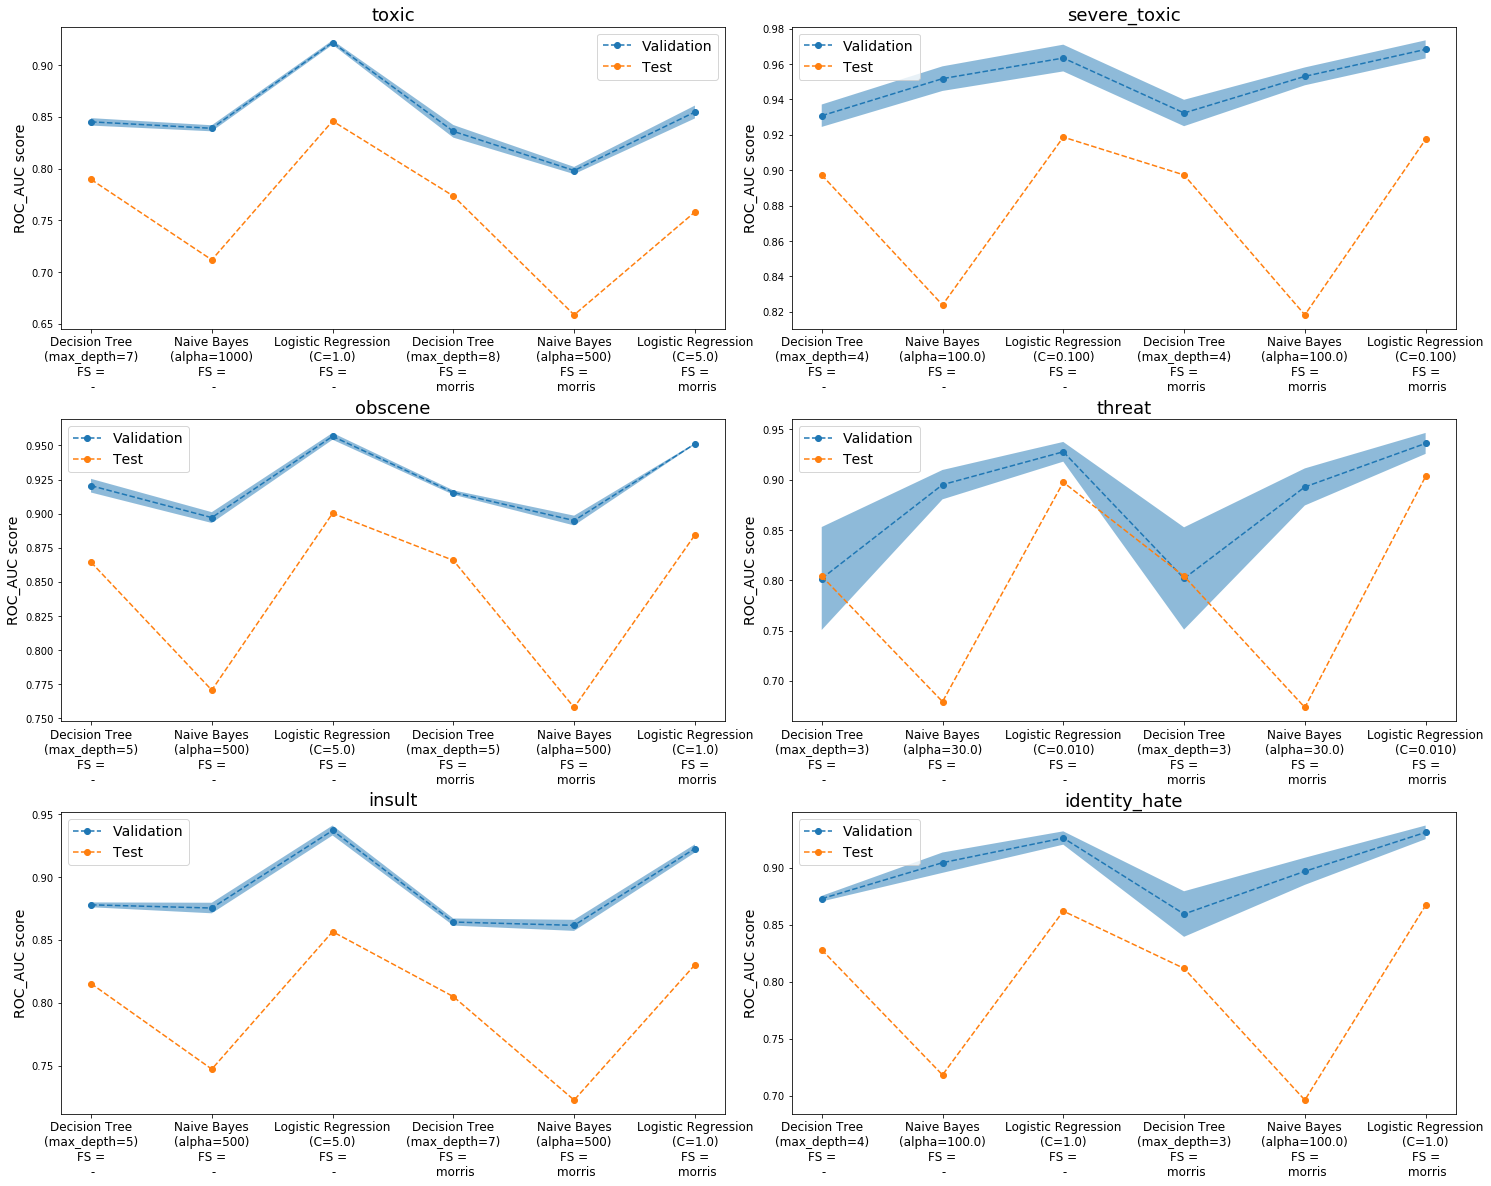

In [370]:
import ast
res = results

def parse_param(param_dict):
    if isinstance(param_dict, str):
        param_dict = ast.literal_eval(param_dict)
    names = param_dict.keys()
    values = [str(v) if float(v).is_integer() else "{:.3f}".format(v) for v in param_dict.values()]
    return "({})".format(", ".join(["{}={}".format(k, v) for k, v in zip(names, values)]))

def make_model_names(df):
    models = df['Model']
    params = [parse_param(p) for p in df['Parameters']]
    feature_selection = [("\nFS =\n "+fs if fs else "") 
                         for fs in df['FeatureSelection']]
    return ["{}\n{}{}".format(mn, p, fs) 
            for mn, p, fs in zip(models, params, feature_selection)]

def plot_one_target(ax, df, target):
    res = df.query('Target==@target').fillna('')
    model_names = make_model_names(res)
    x_range = range(len(model_names))
    val_score, val_std = res['ValidationScore'], res['Std']
    ax.plot(x_range, val_score, 'o--', label='Validation')
    ax.plot(x_range, res['TestScore'], 'o--', label='Test')
    ax.fill_between(x_range, val_score - val_std, val_score + val_std, alpha=0.5)
    ax.set_xticks(x_range)
    ax.set_xticklabels(model_names, fontsize=12)
    ax.set_ylabel('ROC_AUC score', fontsize=14)
    ax.set_title(target, fontsize=18)
    ax.legend(fontsize=14)

fig9, axes = plt.subplots(3, 2, figsize=(25, 20))
for i, label in enumerate(res.Target.unique()):
    plot_one_target(axes[i//2, i%2], res, label)
plt.subplots_adjust(wspace=0.1, hspace=0.3);

In [371]:
fig9.savefig('CountVec_SVD_result.pdf', bbox_inches='tight')

In [373]:
results.to_csv('results_CountVec.csv')